In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [2]:
# Read fake and real news datasets
fake_df = pd.read_csv('/kaggle/input/fake-news-detection/Fake.csv')
real_df = pd.read_csv('/kaggle/input/fake-news-detection/True.csv')

In [3]:
# Check for missing values in both datasets
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [4]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
# Identify unique subjects in both datasets
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [6]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [7]:
# Remove date and subject columns from both datasets
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

In [8]:
# Add a 'class' column to indicate real (1) or fake (0) news
fake_df['class'] = 0 
real_df['class'] = 1

Text(0, 0.5, 'Proportion of News Articles')

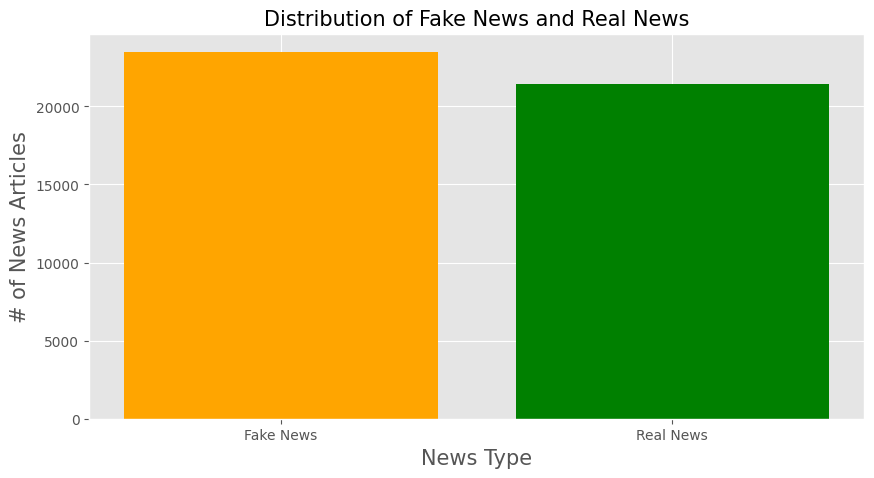

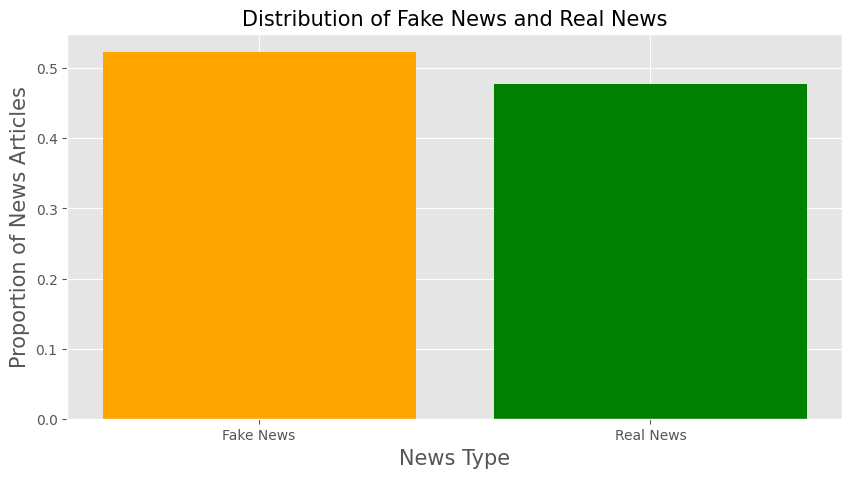

In [9]:
# Visualize the distribution of fake and real news articles
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [10]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [11]:
# Concatenate both datasets into one
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [12]:
# Combine 'title' and 'text' columns into a single 'text' column and drop 'title'
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [13]:
# Split the dataset into features and targets
features = news_df['text']
targets = news_df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [14]:
# Define a function to normalize the text data
def normalize(data):
    # Create an empty list to store the normalized text data
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

# Normalize the text data in the training and testing sets
X_train = normalize(X_train)
X_test = normalize(X_test)

In [15]:
# Set the maximum vocabulary size
max_vocab = 10000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [16]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
# Pad the sequences to a fixed length
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [18]:
# Building the RNN
# Create a sequential model to stack the layers
model = tf.keras.Sequential([
    # Add an embedding layer with a specified vocabulary size (max_vocab) and 128-dimensional vectors
    #The embedding layer is used to convert words (or tokens) in the text data into dense vectors of fixed size.
    tf.keras.layers.Embedding(max_vocab, 128),
    # Add a bidirectional LSTM layer with 64 units that returns sequences
    #Bidirectional LSTM layers are used to capture both past and future context of words in a sequence.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    # Add another bidirectional LSTM layer with 16 units (no return sequences)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # Add a fully connected dense layer with 64 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),
    # Add a dropout layer to Reduces Overfitting and Enhances Model Performance
    tf.keras.layers.Dropout(0.5),
     # Add the final dense layer with 1 unit, representing binary classification (0 or 1) using sigmoid activation
    tf.keras.layers.Dense(1)
])

# Display a summary of the model architecture, including layer types, output shape, and parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [19]:

# We use early_stop to prevent the model from continuing training when it has reached a point where it is no longer improving on the validation dataset.
#This helps avoid overfitting and saves training time. 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 235s 213ms/step - loss: 0.2442 - accuracy: 0.8674 - val_loss: 0.0542 - val_accuracy: 0.9866
Epoch 2/10
1078/1078 [==============================] - 224s 208ms/step - loss: 0.0462 - accuracy: 0.9874 - val_loss: 0.0342 - val_accuracy: 0.9900
Epoch 3/10
1078/1078 [==============================] - 224s 208ms/step - loss: 0.0235 - accuracy: 0.9945 - val_loss: 0.0295 - val_accuracy: 0.9894
Epoch 4/10
1078/1078 [==============================] - 226s 210ms/step - loss: 0.0119 - accuracy: 0.9970 - val_loss: 0.0433 - val_accuracy: 0.9883
Epoch 5/10
1078/1078 [==============================] - 226s 210ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0316 - val_accuracy: 0.9916


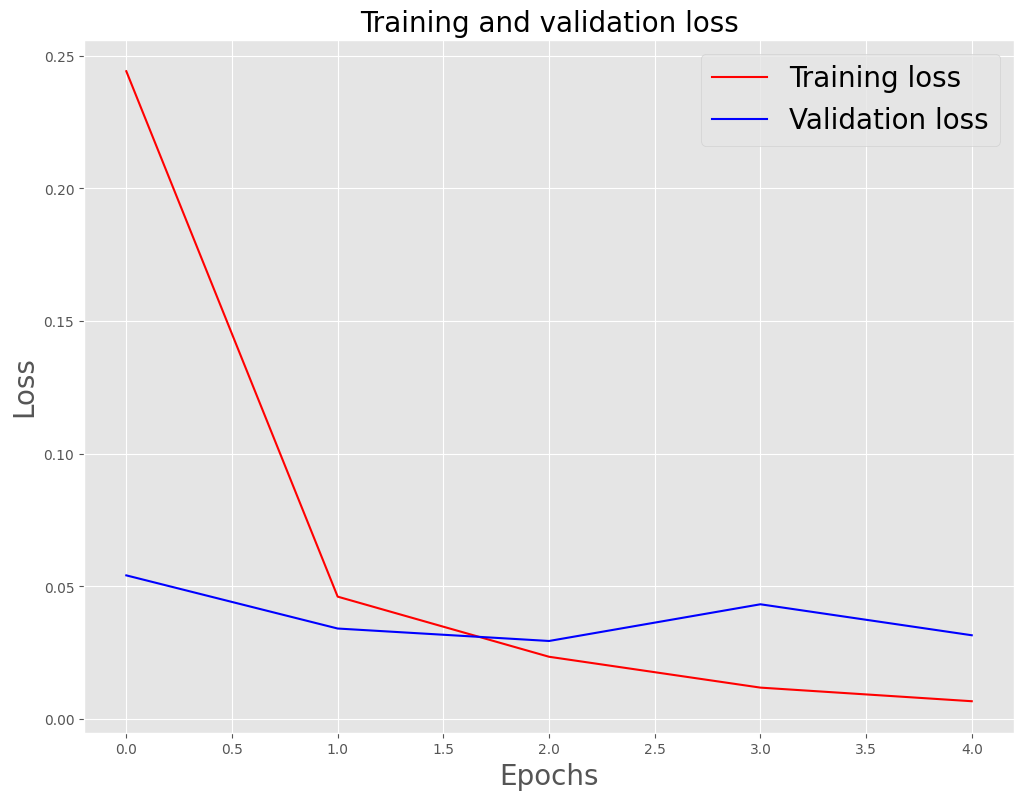

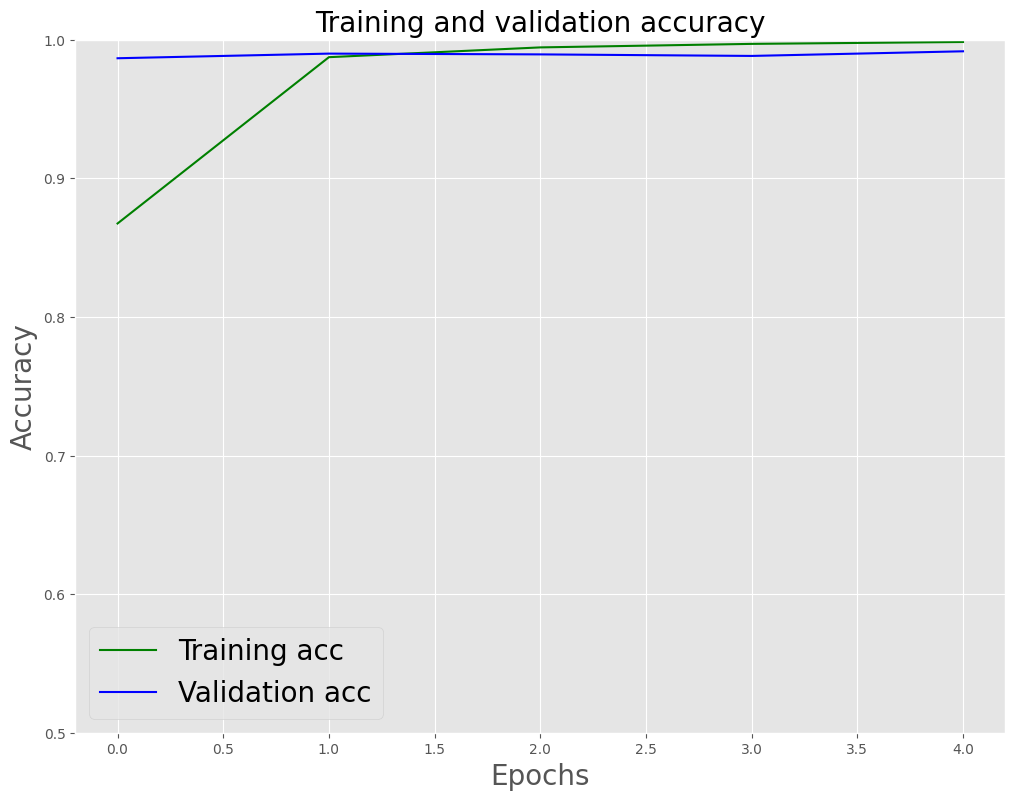

In [20]:
# Plot training and validation loss
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [21]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 14s 49ms/step - loss: 0.0290 - accuracy: 0.9912


[0.029021359980106354, 0.9912026524543762]

In [22]:
# Make predictions and calculate metrics
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 15s 49ms/step


In [23]:
# Calculate accuracy, precision, recall, and plot a confusion matrix
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9912026726057906
Precision on testing set: 0.9877257989810098
Recall on testing set: 0.9939408063388487


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

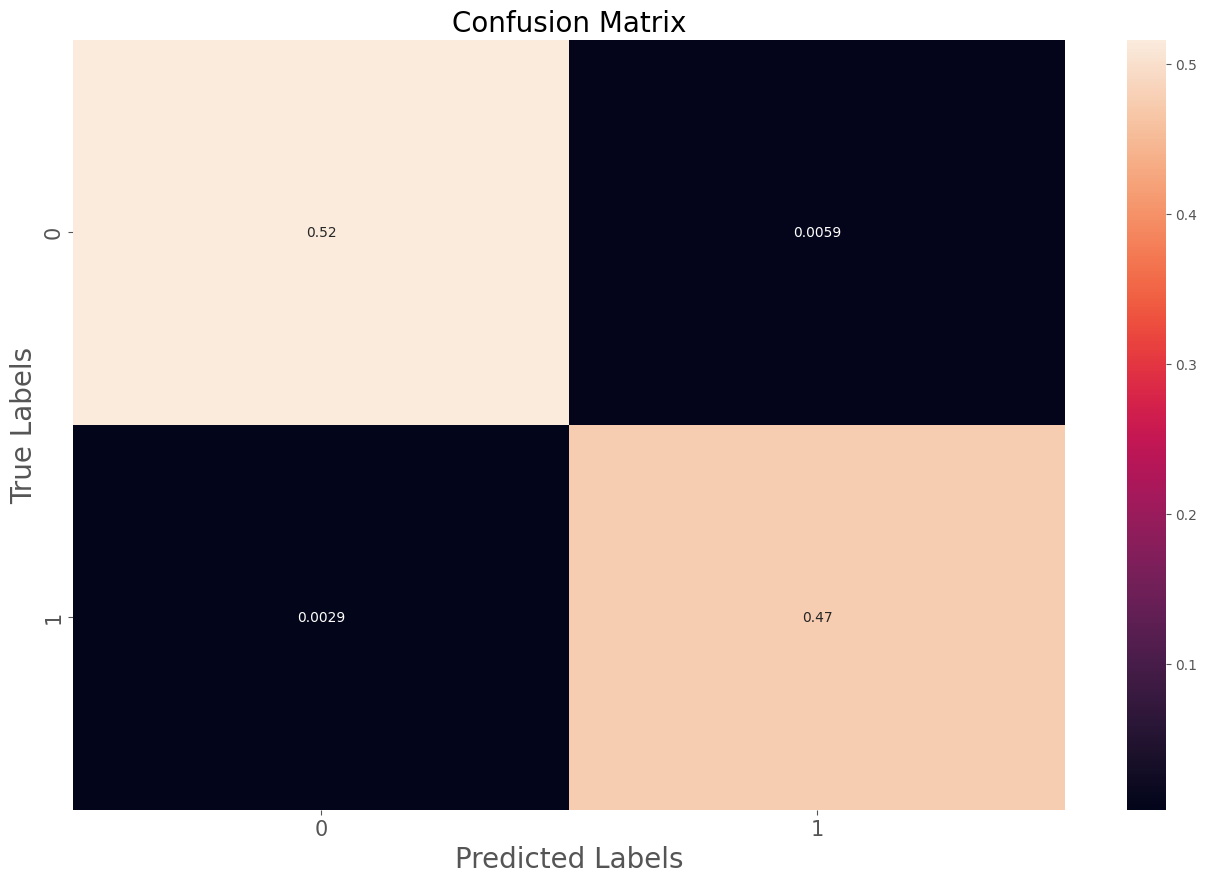

In [24]:
#confusion_matrix is used to assess the performance of a binary classification model.
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)